In [39]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from tqdm import tqdm

In [40]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [41]:
X_test = np.load("Data/X_test.npy")
y_test = np.load("Data/y_test.npy")
person_train_valid = np.load("Data/person_train_valid.npy")
X_train_valid = np.load("Data/X_train_valid.npy")
y_train_valid = np.load("Data/y_train_valid.npy")
person_test = np.load("Data/person_test.npy")

### Preprocess data

In [42]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [43]:
inx_valid = np.random.choice(2115, 500, replace=False)
inx_train = np.array(list(set(range(2115)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)


In [44]:
def change_label(y):
    for i in range(len(y)):
        if y[i] == 769:
            y[i] = 0
        elif y[i] == 770:
            y[i] = 1
        elif y[i] == 771:
            y[i] = 2
        else:
            y[i] = 3
    return y

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

# y_train = to_categorical(change_label(y_train), 4)
# y_valid = to_categorical(change_label(y_valid), 4)
# y_test = to_categorical(change_label(y_test), 4)

y_train = change_label(y_train)
y_valid = change_label(y_valid)
y_test = change_label(y_test)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

Shape of training labels after categorical conversion: (1615,)
Shape of validation labels after categorical conversion: (500,)
Shape of test labels after categorical conversion: (443,)


In [45]:
# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2])
x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

Shape of training set after adding width info: (1615, 1, 22, 1000)
Shape of validation set after adding width info: (500, 1, 22, 1000)
Shape of test set after adding width info: (443, 1, 22, 1000)


/var/folders/db/7f5kjc1s7pgfl7w2njwstwym0000gn/T/ipykernel_25663/3414961565.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


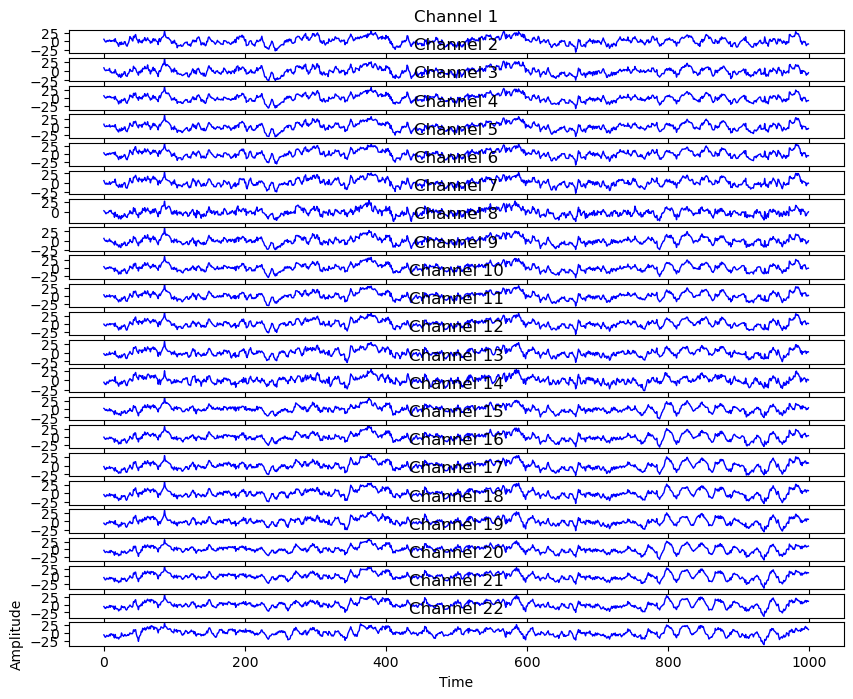

In [46]:
num_trial, num_channel, time_bin = X_train_valid.shape
trial_1 = X_train_valid[0]

for i in range(num_channel):
    plt.subplot(num_channel, 1, i+1)
    plt.plot(trial_1[i], color='b', linewidth=1)
    plt.title('Channel {}'.format(i+1))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [47]:
bsz = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bsz, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=bsz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bsz, shuffle=True)

print(len(train_loader), len(val_loader), len(test_loader))

33 10 9


In [48]:
# if torch.cuda.is_available():
#   device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#   device = torch.device('mps')
# else:
#   device = torch.device('cpu')

# print("Using", device)

device = torch.device('cpu')
print("Using", device)

Using cpu


In [59]:
def trainer(model):
    cel_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    
    history = {
        'train_acc':[],
        'val_acc':[],
        'train_loss':[],
        'val_loss':[],
    }
    
    best_val = 0.

    for epoch in tqdm(range(epochs)):
        model.train()
        train_count = 0
        train_correct_count = 0
        for i, (x_train, y_train) in enumerate(train_loader):

            x_train = x_train.reshape(-1, time_bin, num_channel).float().to(device)
            y_train = y_train.long().to(device)

            optimizer.zero_grad()
            logits = model(x_train)
            loss = cel_loss(logits, y_train)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == y_train, axis=-1)
                train_count += x_train.shape[0]
        train_acc = train_correct_count / train_count

        model.eval()
        val_count = 0
        val_correct_count = 0
        
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.reshape(-1, time_bin, num_channel).float().to(device)
                val_y = val_y.long().to(device)
                logits = model(val_x).detach()
                val_loss = cel_loss(logits, val_y)
                
                y_hat = torch.argmax(logits, dim=-1)
                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_x.shape[0]
                
            val_acc = val_correct_count / val_count
        
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        
        if val_acc > best_val:
            best_val = val_acc

        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))
        print('Train loss: {:.3f}, Val loss: {:.3f}'.format(loss, val_loss))
        
    print('Best validation Accuracy: {:.3f}'.format(best_val))
        
    return history

def tester(model):
    model.eval()
    test_count = 0
    test_correct_count = 0

    with torch.no_grad():
        for idx, (test_x, test_y) in enumerate(test_loader):
            test_x = val_x.float().to(device)
            test_y = val_y.float().to(device)
            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.shape[0]
        test_acc = test_correct_count / test_count

    print('Test acc: {:.3f}', format(test_acc))

In [89]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        
        # Declare fixed parameters for EEGNet
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        # out: (batch_size, seq_length, hidden_size)
        
        out = out[:, -1, :]
        # out: (batch_size, hidden_size)
        
        out = self.fc(out)
        
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        
        # Declare fixed parameters for EEGNet
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0,c0))
        # out: (batch_size, seq_length, hidden_size)
        
        out = out[:, -1, :]
        # out: (batch_size, hidden_size)
        out = self.fc(out)
        
        return out

In [61]:
RNN_history = trainer(RNN(22, 32, 2, 4))

  2%|▉                                           | 1/50 [00:03<02:51,  3.50s/it]

Train acc: 0.246, Val acc: 0.244
Train loss: 1.409, Val loss: 1.414


  4%|█▊                                          | 2/50 [00:06<02:44,  3.44s/it]

Train acc: 0.296, Val acc: 0.246
Train loss: 1.290, Val loss: 1.431


  6%|██▋                                         | 3/50 [00:10<02:40,  3.41s/it]

Train acc: 0.344, Val acc: 0.254
Train loss: 1.343, Val loss: 1.414


  8%|███▌                                        | 4/50 [00:13<02:37,  3.43s/it]

Train acc: 0.370, Val acc: 0.260
Train loss: 1.439, Val loss: 1.351


 10%|████▍                                       | 5/50 [00:17<02:34,  3.44s/it]

Train acc: 0.383, Val acc: 0.252
Train loss: 1.426, Val loss: 1.400


 12%|█████▎                                      | 6/50 [00:20<02:31,  3.44s/it]

Train acc: 0.404, Val acc: 0.258
Train loss: 1.302, Val loss: 1.374


 14%|██████▏                                     | 7/50 [00:24<02:30,  3.51s/it]

Train acc: 0.414, Val acc: 0.260
Train loss: 1.278, Val loss: 1.454


 16%|███████                                     | 8/50 [00:27<02:27,  3.50s/it]

Train acc: 0.423, Val acc: 0.260
Train loss: 1.307, Val loss: 1.455


 18%|███████▉                                    | 9/50 [00:31<02:26,  3.57s/it]

Train acc: 0.451, Val acc: 0.256
Train loss: 1.171, Val loss: 1.526


 20%|████████▌                                  | 10/50 [00:35<02:22,  3.56s/it]

Train acc: 0.453, Val acc: 0.254
Train loss: 1.140, Val loss: 1.426


 22%|█████████▍                                 | 11/50 [00:38<02:18,  3.56s/it]

Train acc: 0.465, Val acc: 0.256
Train loss: 1.340, Val loss: 1.417


 24%|██████████▎                                | 12/50 [00:42<02:15,  3.56s/it]

Train acc: 0.498, Val acc: 0.258
Train loss: 1.325, Val loss: 1.500


 26%|███████████▏                               | 13/50 [00:45<02:10,  3.54s/it]

Train acc: 0.499, Val acc: 0.242
Train loss: 1.206, Val loss: 1.548


 28%|████████████                               | 14/50 [00:49<02:07,  3.54s/it]

Train acc: 0.517, Val acc: 0.260
Train loss: 1.167, Val loss: 1.545


 30%|████████████▉                              | 15/50 [00:52<02:03,  3.53s/it]

Train acc: 0.534, Val acc: 0.252
Train loss: 1.240, Val loss: 1.622


 32%|█████████████▊                             | 16/50 [00:56<01:59,  3.53s/it]

Train acc: 0.531, Val acc: 0.256
Train loss: 1.164, Val loss: 1.596


 34%|██████████████▌                            | 17/50 [00:59<01:56,  3.53s/it]

Train acc: 0.564, Val acc: 0.260
Train loss: 1.102, Val loss: 1.625


 36%|███████████████▍                           | 18/50 [01:03<01:52,  3.53s/it]

Train acc: 0.558, Val acc: 0.248
Train loss: 1.352, Val loss: 1.619


 38%|████████████████▎                          | 19/50 [01:06<01:50,  3.56s/it]

Train acc: 0.588, Val acc: 0.266
Train loss: 0.960, Val loss: 1.623


 40%|█████████████████▏                         | 20/50 [01:10<01:46,  3.55s/it]

Train acc: 0.604, Val acc: 0.254
Train loss: 1.035, Val loss: 1.679


 42%|██████████████████                         | 21/50 [01:14<01:43,  3.56s/it]

Train acc: 0.609, Val acc: 0.252
Train loss: 1.112, Val loss: 1.536


 44%|██████████████████▉                        | 22/50 [01:17<01:39,  3.55s/it]

Train acc: 0.612, Val acc: 0.266
Train loss: 1.152, Val loss: 1.768


 46%|███████████████████▊                       | 23/50 [01:21<01:35,  3.52s/it]

Train acc: 0.630, Val acc: 0.252
Train loss: 1.126, Val loss: 1.849


 48%|████████████████████▋                      | 24/50 [01:24<01:32,  3.56s/it]

Train acc: 0.642, Val acc: 0.250
Train loss: 1.528, Val loss: 1.759


 50%|█████████████████████▌                     | 25/50 [01:28<01:28,  3.55s/it]

Train acc: 0.654, Val acc: 0.252
Train loss: 1.222, Val loss: 2.036


 52%|██████████████████████▎                    | 26/50 [01:31<01:25,  3.57s/it]

Train acc: 0.672, Val acc: 0.248
Train loss: 1.070, Val loss: 1.997


 54%|███████████████████████▏                   | 27/50 [01:35<01:21,  3.55s/it]

Train acc: 0.669, Val acc: 0.244
Train loss: 0.885, Val loss: 2.134


 56%|████████████████████████                   | 28/50 [01:38<01:18,  3.55s/it]

Train acc: 0.679, Val acc: 0.246
Train loss: 1.096, Val loss: 1.744


 58%|████████████████████████▉                  | 29/50 [01:42<01:14,  3.54s/it]

Train acc: 0.705, Val acc: 0.230
Train loss: 0.947, Val loss: 1.972


 60%|█████████████████████████▊                 | 30/50 [01:46<01:11,  3.58s/it]

Train acc: 0.711, Val acc: 0.232
Train loss: 1.025, Val loss: 2.071


 62%|██████████████████████████▋                | 31/50 [01:49<01:07,  3.56s/it]

Train acc: 0.727, Val acc: 0.228
Train loss: 0.619, Val loss: 2.022


 64%|███████████████████████████▌               | 32/50 [01:53<01:04,  3.60s/it]

Train acc: 0.736, Val acc: 0.220
Train loss: 0.900, Val loss: 1.776


 66%|████████████████████████████▍              | 33/50 [01:56<01:01,  3.61s/it]

Train acc: 0.743, Val acc: 0.228
Train loss: 1.046, Val loss: 1.921


 68%|█████████████████████████████▏             | 34/50 [02:00<00:57,  3.60s/it]

Train acc: 0.757, Val acc: 0.252
Train loss: 0.699, Val loss: 2.052


 70%|██████████████████████████████             | 35/50 [02:04<00:53,  3.59s/it]

Train acc: 0.768, Val acc: 0.232
Train loss: 0.816, Val loss: 2.165


 72%|██████████████████████████████▉            | 36/50 [02:07<00:49,  3.57s/it]

Train acc: 0.773, Val acc: 0.234
Train loss: 1.113, Val loss: 2.088


 74%|███████████████████████████████▊           | 37/50 [02:11<00:46,  3.55s/it]

Train acc: 0.776, Val acc: 0.234
Train loss: 0.484, Val loss: 2.127


 76%|████████████████████████████████▋          | 38/50 [02:14<00:43,  3.59s/it]

Train acc: 0.798, Val acc: 0.246
Train loss: 0.576, Val loss: 2.399


 78%|█████████████████████████████████▌         | 39/50 [02:18<00:39,  3.60s/it]

Train acc: 0.806, Val acc: 0.264
Train loss: 0.478, Val loss: 2.361


 80%|██████████████████████████████████▍        | 40/50 [02:21<00:36,  3.62s/it]

Train acc: 0.816, Val acc: 0.256
Train loss: 0.514, Val loss: 2.352


 82%|███████████████████████████████████▎       | 41/50 [02:25<00:32,  3.62s/it]

Train acc: 0.817, Val acc: 0.244
Train loss: 0.719, Val loss: 2.618


 84%|████████████████████████████████████       | 42/50 [02:29<00:28,  3.61s/it]

Train acc: 0.829, Val acc: 0.254
Train loss: 0.330, Val loss: 2.181


 86%|████████████████████████████████████▉      | 43/50 [02:32<00:25,  3.62s/it]

Train acc: 0.846, Val acc: 0.254
Train loss: 0.596, Val loss: 2.512


 88%|█████████████████████████████████████▊     | 44/50 [02:36<00:21,  3.60s/it]

Train acc: 0.841, Val acc: 0.274
Train loss: 0.355, Val loss: 3.275


 90%|██████████████████████████████████████▋    | 45/50 [02:40<00:18,  3.62s/it]

Train acc: 0.859, Val acc: 0.248
Train loss: 0.615, Val loss: 2.317


 92%|███████████████████████████████████████▌   | 46/50 [02:43<00:14,  3.64s/it]

Train acc: 0.870, Val acc: 0.260
Train loss: 0.475, Val loss: 2.774


 94%|████████████████████████████████████████▍  | 47/50 [02:47<00:10,  3.65s/it]

Train acc: 0.884, Val acc: 0.274
Train loss: 0.388, Val loss: 2.864


 96%|█████████████████████████████████████████▎ | 48/50 [02:51<00:07,  3.65s/it]

Train acc: 0.886, Val acc: 0.254
Train loss: 0.543, Val loss: 2.951


 98%|██████████████████████████████████████████▏| 49/50 [02:54<00:03,  3.63s/it]

Train acc: 0.887, Val acc: 0.256
Train loss: 0.316, Val loss: 3.245


100%|███████████████████████████████████████████| 50/50 [02:58<00:00,  3.57s/it]

Train acc: 0.897, Val acc: 0.248
Train loss: 0.355, Val loss: 3.058
Best validation Accuracy: 0.274


Text(0.5, 1.0, 'RNN Model Accuracy On Raw Data')

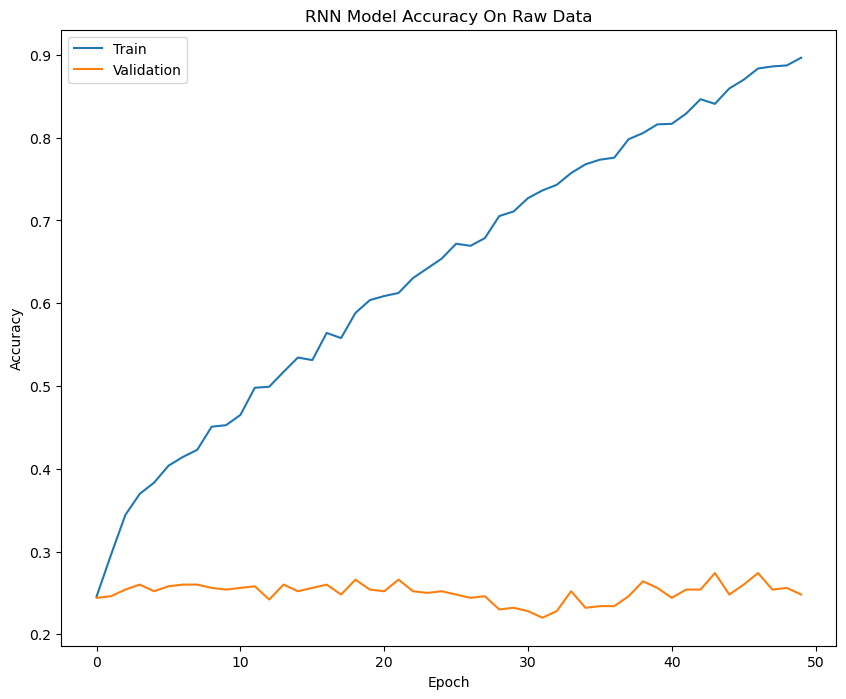

In [83]:
plt.plot(np.arange(50), RNN_history['train_acc'], label='Train')
plt.plot(np.arange(50), RNN_history['val_acc'], label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Model Accuracy On Raw Data')

Text(0.5, 1.0, 'RNN Model Loss On Raw Data')

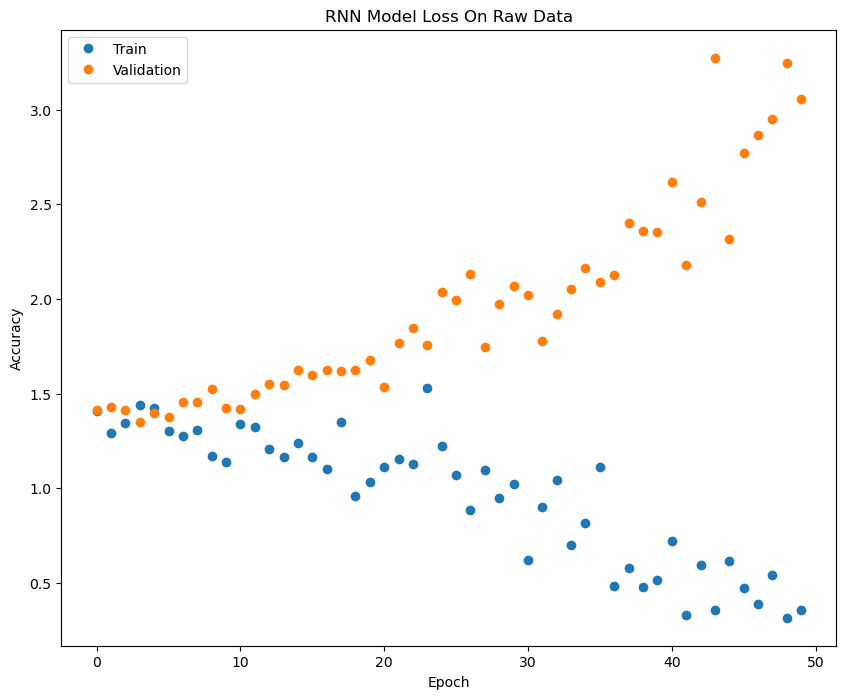

In [85]:
plt.plot(np.arange(50), RNN_history['train_loss'], 'o', label='Train')
plt.plot(np.arange(50), RNN_history['val_loss'], 'o', label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Model Loss On Raw Data')

In [80]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN2, self).__init__()
        
        T = 1000
        
        # Declare fixed parameters for EEGNet
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.BN_DO = nn.Sequential(
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size*T, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x, _ = self.rnn1(x, h0)
        # out: (batch_size, seq_length, hidden_size)
        
        x = x.permute(0,2,1)
        x = self.BN_DO(x)
            
        x = x.permute(0,2,1)
        x, _ = self.rnn2(x, h0)
        
#         out = out[:, -1, :]
        # out: (batch_size, hidden_size)
#         print(x.shape)
        x = self.flatten(x)
        x = self.fc(x)
#         print(x.shape)
        x = self.softmax(x)
        
        return x

In [81]:
RNN2_history = trainer(RNN2(22, 32, 2, 4))

  2%|▉                                           | 1/50 [00:07<06:08,  7.53s/it]

Train acc: 0.269, Val acc: 0.336
Train loss: 1.337, Val loss: 1.354


  4%|█▊                                          | 2/50 [00:15<06:01,  7.53s/it]

Train acc: 0.451, Val acc: 0.348
Train loss: 1.198, Val loss: 1.428


  6%|██▋                                         | 3/50 [00:22<05:53,  7.51s/it]

Train acc: 0.612, Val acc: 0.336
Train loss: 1.179, Val loss: 1.421


  8%|███▌                                        | 4/50 [00:30<05:46,  7.52s/it]

Train acc: 0.744, Val acc: 0.350
Train loss: 0.966, Val loss: 1.336


 10%|████▍                                       | 5/50 [00:37<05:38,  7.51s/it]

Train acc: 0.812, Val acc: 0.350
Train loss: 0.972, Val loss: 1.397


 12%|█████▎                                      | 6/50 [00:45<05:31,  7.53s/it]

Train acc: 0.853, Val acc: 0.358
Train loss: 0.909, Val loss: 1.365


 14%|██████▏                                     | 7/50 [00:52<05:23,  7.53s/it]

Train acc: 0.890, Val acc: 0.348
Train loss: 0.881, Val loss: 1.397


 16%|███████                                     | 8/50 [01:00<05:16,  7.53s/it]

Train acc: 0.905, Val acc: 0.342
Train loss: 0.816, Val loss: 1.266


 18%|███████▉                                    | 9/50 [01:07<05:09,  7.56s/it]

Train acc: 0.920, Val acc: 0.338
Train loss: 0.815, Val loss: 1.355


 20%|████████▌                                  | 10/50 [01:15<05:02,  7.57s/it]

Train acc: 0.929, Val acc: 0.342
Train loss: 0.812, Val loss: 1.447


 22%|█████████▍                                 | 11/50 [01:23<04:55,  7.57s/it]

Train acc: 0.933, Val acc: 0.344
Train loss: 0.746, Val loss: 1.390


 24%|██████████▎                                | 12/50 [01:30<04:48,  7.60s/it]

Train acc: 0.940, Val acc: 0.326
Train loss: 0.872, Val loss: 1.517


 26%|███████████▏                               | 13/50 [01:38<04:41,  7.61s/it]

Train acc: 0.941, Val acc: 0.336
Train loss: 0.870, Val loss: 1.370


 28%|████████████                               | 14/50 [01:45<04:33,  7.61s/it]

Train acc: 0.948, Val acc: 0.348
Train loss: 0.746, Val loss: 1.231


 30%|████████████▉                              | 15/50 [01:53<04:27,  7.64s/it]

Train acc: 0.950, Val acc: 0.344
Train loss: 0.812, Val loss: 1.372


 32%|█████████████▊                             | 16/50 [02:01<04:20,  7.67s/it]

Train acc: 0.950, Val acc: 0.338
Train loss: 0.745, Val loss: 1.418


 34%|██████████████▌                            | 17/50 [02:08<04:12,  7.66s/it]

Train acc: 0.951, Val acc: 0.336
Train loss: 0.811, Val loss: 1.420


 36%|███████████████▍                           | 18/50 [02:16<04:04,  7.63s/it]

Train acc: 0.952, Val acc: 0.360
Train loss: 0.810, Val loss: 1.348


 38%|████████████████▎                          | 19/50 [02:24<03:55,  7.61s/it]

Train acc: 0.954, Val acc: 0.362
Train loss: 0.745, Val loss: 1.448


 40%|█████████████████▏                         | 20/50 [02:31<03:47,  7.59s/it]

Train acc: 0.955, Val acc: 0.340
Train loss: 0.870, Val loss: 1.342


 42%|██████████████████                         | 21/50 [02:39<03:39,  7.57s/it]

Train acc: 0.957, Val acc: 0.350
Train loss: 0.745, Val loss: 1.311


 44%|██████████████████▉                        | 22/50 [02:46<03:32,  7.60s/it]

Train acc: 0.958, Val acc: 0.352
Train loss: 0.745, Val loss: 1.385


 46%|███████████████████▊                       | 23/50 [02:55<03:33,  7.92s/it]

Train acc: 0.959, Val acc: 0.338
Train loss: 0.748, Val loss: 1.299


 48%|████████████████████▋                      | 24/50 [03:03<03:26,  7.93s/it]

Train acc: 0.960, Val acc: 0.324
Train loss: 0.812, Val loss: 1.303


 50%|█████████████████████▌                     | 25/50 [03:11<03:18,  7.95s/it]

Train acc: 0.961, Val acc: 0.322
Train loss: 0.812, Val loss: 1.411


 52%|██████████████████████▎                    | 26/50 [03:19<03:10,  7.93s/it]

Train acc: 0.962, Val acc: 0.340
Train loss: 0.880, Val loss: 1.380


 54%|███████████████████████▏                   | 27/50 [03:27<03:03,  7.96s/it]

Train acc: 0.962, Val acc: 0.330
Train loss: 0.893, Val loss: 1.329


 56%|████████████████████████                   | 28/50 [03:35<02:53,  7.89s/it]

Train acc: 0.962, Val acc: 0.348
Train loss: 0.822, Val loss: 1.476


 58%|████████████████████████▉                  | 29/50 [03:42<02:44,  7.81s/it]

Train acc: 0.957, Val acc: 0.360
Train loss: 0.748, Val loss: 1.517


 60%|█████████████████████████▊                 | 30/50 [03:50<02:36,  7.82s/it]

Train acc: 0.960, Val acc: 0.334
Train loss: 0.758, Val loss: 1.383


 62%|██████████████████████████▋                | 31/50 [03:58<02:28,  7.82s/it]

Train acc: 0.950, Val acc: 0.326
Train loss: 0.778, Val loss: 1.369


 64%|███████████████████████████▌               | 32/50 [04:06<02:21,  7.85s/it]

Train acc: 0.940, Val acc: 0.322
Train loss: 0.810, Val loss: 1.403


 66%|████████████████████████████▍              | 33/50 [04:14<02:13,  7.84s/it]

Train acc: 0.946, Val acc: 0.320
Train loss: 0.969, Val loss: 1.453


 68%|█████████████████████████████▏             | 34/50 [04:21<02:05,  7.83s/it]

Train acc: 0.928, Val acc: 0.306
Train loss: 0.870, Val loss: 1.369


 70%|██████████████████████████████             | 35/50 [04:29<01:57,  7.84s/it]

Train acc: 0.939, Val acc: 0.322
Train loss: 0.810, Val loss: 1.477


 72%|██████████████████████████████▉            | 36/50 [04:37<01:49,  7.85s/it]

Train acc: 0.942, Val acc: 0.306
Train loss: 0.806, Val loss: 1.365


 74%|███████████████████████████████▊           | 37/50 [04:45<01:41,  7.83s/it]

Train acc: 0.944, Val acc: 0.318
Train loss: 0.892, Val loss: 1.406


 76%|████████████████████████████████▋          | 38/50 [04:53<01:34,  7.83s/it]

Train acc: 0.946, Val acc: 0.302
Train loss: 0.894, Val loss: 1.430


 78%|█████████████████████████████████▌         | 39/50 [05:01<01:26,  7.87s/it]

Train acc: 0.946, Val acc: 0.324
Train loss: 0.812, Val loss: 1.444


 80%|██████████████████████████████████▍        | 40/50 [05:09<01:18,  7.87s/it]

Train acc: 0.957, Val acc: 0.334
Train loss: 0.747, Val loss: 1.329


 82%|███████████████████████████████████▎       | 41/50 [05:16<01:10,  7.87s/it]

Train acc: 0.958, Val acc: 0.330
Train loss: 0.817, Val loss: 1.434


 84%|████████████████████████████████████       | 42/50 [05:24<01:02,  7.85s/it]

Train acc: 0.956, Val acc: 0.328
Train loss: 0.744, Val loss: 1.492


 86%|████████████████████████████████████▉      | 43/50 [05:32<00:54,  7.79s/it]

Train acc: 0.962, Val acc: 0.328
Train loss: 0.744, Val loss: 1.438


 88%|█████████████████████████████████████▊     | 44/50 [05:40<00:46,  7.76s/it]

Train acc: 0.961, Val acc: 0.316
Train loss: 0.744, Val loss: 1.485


 90%|██████████████████████████████████████▋    | 45/50 [05:47<00:38,  7.73s/it]

Train acc: 0.968, Val acc: 0.346
Train loss: 0.744, Val loss: 1.387


 92%|███████████████████████████████████████▌   | 46/50 [05:55<00:30,  7.71s/it]

Train acc: 0.967, Val acc: 0.328
Train loss: 0.847, Val loss: 1.343


 94%|████████████████████████████████████████▍  | 47/50 [06:03<00:23,  7.71s/it]

Train acc: 0.963, Val acc: 0.336
Train loss: 0.744, Val loss: 1.364


 96%|█████████████████████████████████████████▎ | 48/50 [06:10<00:15,  7.69s/it]

Train acc: 0.967, Val acc: 0.328
Train loss: 0.810, Val loss: 1.315


 98%|██████████████████████████████████████████▏| 49/50 [06:18<00:07,  7.68s/it]

Train acc: 0.969, Val acc: 0.338
Train loss: 0.745, Val loss: 1.384


100%|███████████████████████████████████████████| 50/50 [06:26<00:00,  7.72s/it]

Train acc: 0.970, Val acc: 0.330
Train loss: 0.810, Val loss: 1.404
Best validation Accuracy: 0.362


Text(0.5, 1.0, 'RNN Model Accuracy On Raw Data')

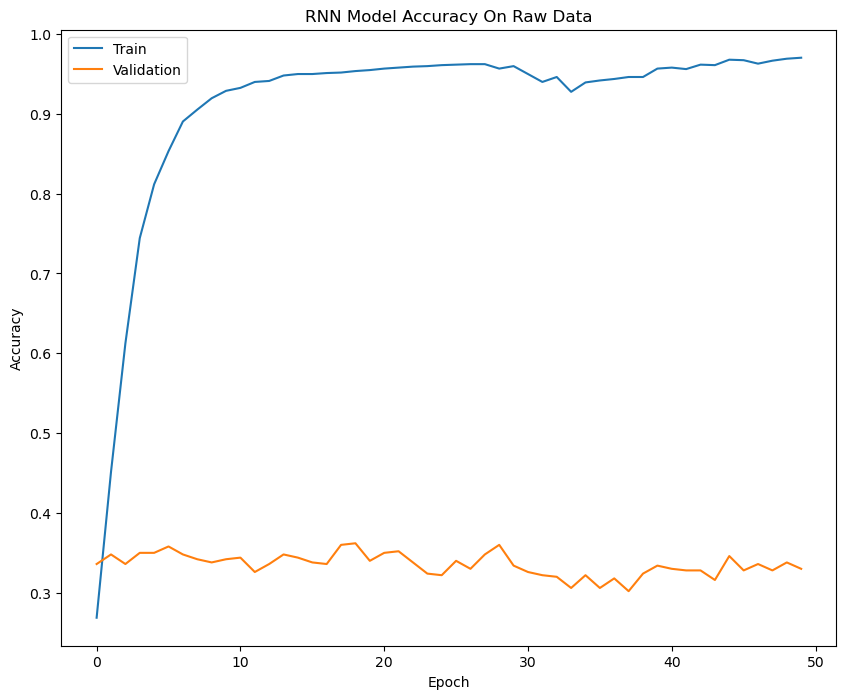

In [86]:
plt.plot(np.arange(50), RNN2_history['train_acc'], label='Train')
plt.plot(np.arange(50), RNN2_history['val_acc'], label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Model Accuracy On Raw Data')

Text(0.5, 1.0, 'RNN Model Loss On Raw Data')

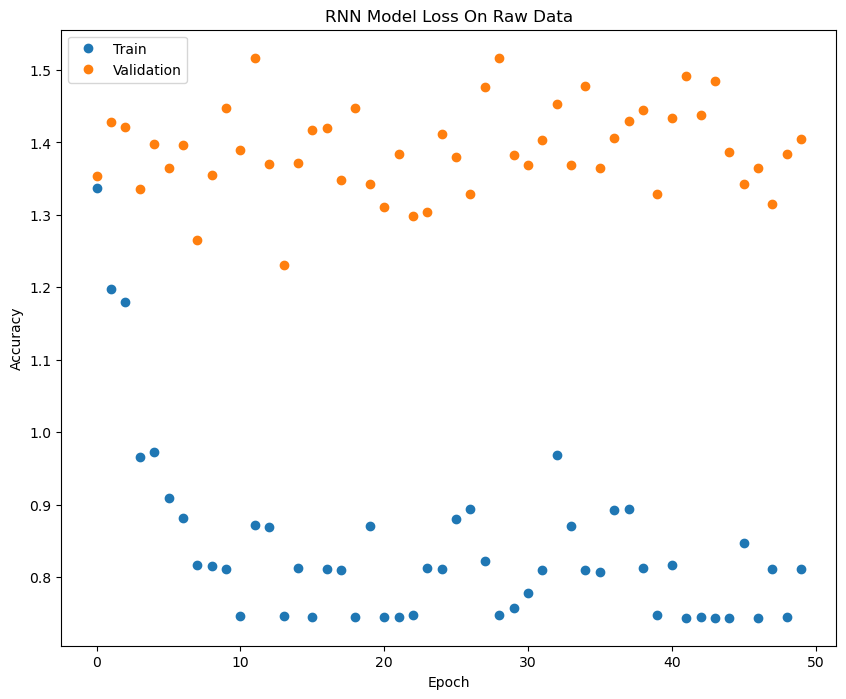

In [87]:
plt.plot(np.arange(50), RNN2_history['train_loss'], 'o', label='Train')
plt.plot(np.arange(50), RNN2_history['val_loss'], 'o', label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RNN Model Loss On Raw Data')

In [90]:
LSTM_history = trainer(LSTM(22, 32, 2, 4))

  2%|▉                                           | 1/50 [00:12<10:07, 12.40s/it]

Train acc: 0.252, Val acc: 0.252
Train loss: 1.399, Val loss: 1.388


  4%|█▊                                          | 2/50 [00:24<09:47, 12.24s/it]

Train acc: 0.287, Val acc: 0.226
Train loss: 1.366, Val loss: 1.386


  6%|██▋                                         | 3/50 [00:36<09:32, 12.19s/it]

Train acc: 0.320, Val acc: 0.218
Train loss: 1.349, Val loss: 1.388


  8%|███▌                                        | 4/50 [00:48<09:23, 12.24s/it]

Train acc: 0.336, Val acc: 0.240
Train loss: 1.300, Val loss: 1.397


 10%|████▍                                       | 5/50 [01:00<09:06, 12.15s/it]

Train acc: 0.375, Val acc: 0.236
Train loss: 1.289, Val loss: 1.408


 12%|█████▎                                      | 6/50 [01:12<08:50, 12.07s/it]

Train acc: 0.395, Val acc: 0.232
Train loss: 1.477, Val loss: 1.441


 14%|██████▏                                     | 7/50 [01:24<08:33, 11.94s/it]

Train acc: 0.429, Val acc: 0.218
Train loss: 1.266, Val loss: 1.592


 16%|███████                                     | 8/50 [01:36<08:17, 11.85s/it]

Train acc: 0.454, Val acc: 0.252
Train loss: 1.347, Val loss: 1.522


 18%|███████▉                                    | 9/50 [01:47<08:03, 11.80s/it]

Train acc: 0.493, Val acc: 0.252
Train loss: 1.138, Val loss: 1.507


 20%|████████▌                                  | 10/50 [01:59<07:50, 11.77s/it]

Train acc: 0.537, Val acc: 0.246
Train loss: 0.980, Val loss: 1.655


 22%|█████████▍                                 | 11/50 [02:11<07:38, 11.76s/it]

Train acc: 0.576, Val acc: 0.248
Train loss: 1.026, Val loss: 1.816


 24%|██████████▎                                | 12/50 [02:23<07:26, 11.75s/it]

Train acc: 0.612, Val acc: 0.242
Train loss: 0.893, Val loss: 1.674


 26%|███████████▏                               | 13/50 [02:34<07:14, 11.73s/it]

Train acc: 0.635, Val acc: 0.228
Train loss: 1.072, Val loss: 1.712


 28%|████████████                               | 14/50 [02:46<07:01, 11.72s/it]

Train acc: 0.664, Val acc: 0.230
Train loss: 0.924, Val loss: 2.053


 30%|████████████▉                              | 15/50 [02:58<06:50, 11.72s/it]

Train acc: 0.703, Val acc: 0.240
Train loss: 0.874, Val loss: 1.964


 32%|█████████████▊                             | 16/50 [03:09<06:39, 11.74s/it]

Train acc: 0.727, Val acc: 0.234
Train loss: 0.541, Val loss: 1.953


 34%|██████████████▌                            | 17/50 [03:21<06:27, 11.75s/it]

Train acc: 0.736, Val acc: 0.240
Train loss: 0.640, Val loss: 2.237


 36%|███████████████▍                           | 18/50 [03:33<06:16, 11.76s/it]

Train acc: 0.742, Val acc: 0.242
Train loss: 1.109, Val loss: 2.279


 38%|████████████████▎                          | 19/50 [03:45<06:04, 11.77s/it]

Train acc: 0.763, Val acc: 0.232
Train loss: 0.451, Val loss: 2.463


 40%|█████████████████▏                         | 20/50 [03:57<05:53, 11.78s/it]

Train acc: 0.811, Val acc: 0.234
Train loss: 0.538, Val loss: 2.129


 42%|██████████████████                         | 21/50 [04:08<05:41, 11.78s/it]

Train acc: 0.835, Val acc: 0.224
Train loss: 1.017, Val loss: 2.344


 44%|██████████████████▉                        | 22/50 [04:20<05:29, 11.78s/it]

Train acc: 0.842, Val acc: 0.246
Train loss: 0.374, Val loss: 2.574


 46%|███████████████████▊                       | 23/50 [04:33<05:22, 11.96s/it]

Train acc: 0.868, Val acc: 0.222
Train loss: 0.247, Val loss: 2.829


 48%|████████████████████▋                      | 24/50 [04:44<05:10, 11.93s/it]

Train acc: 0.868, Val acc: 0.240
Train loss: 0.366, Val loss: 2.630


 50%|█████████████████████▌                     | 25/50 [04:57<04:59, 11.99s/it]

Train acc: 0.889, Val acc: 0.256
Train loss: 0.490, Val loss: 2.804


 52%|██████████████████████▎                    | 26/50 [05:09<04:50, 12.10s/it]

Train acc: 0.877, Val acc: 0.246
Train loss: 0.579, Val loss: 2.794


 54%|███████████████████████▏                   | 27/50 [05:21<04:36, 12.03s/it]

Train acc: 0.901, Val acc: 0.236
Train loss: 0.441, Val loss: 3.079


 56%|████████████████████████                   | 28/50 [05:33<04:23, 11.96s/it]

Train acc: 0.893, Val acc: 0.228
Train loss: 0.213, Val loss: 3.225


 58%|████████████████████████▉                  | 29/50 [05:44<04:10, 11.92s/it]

Train acc: 0.913, Val acc: 0.240
Train loss: 0.324, Val loss: 3.430


 60%|█████████████████████████▊                 | 30/50 [05:56<03:57, 11.87s/it]

Train acc: 0.939, Val acc: 0.240
Train loss: 0.363, Val loss: 3.511


 62%|██████████████████████████▋                | 31/50 [06:08<03:45, 11.85s/it]

Train acc: 0.950, Val acc: 0.238
Train loss: 0.296, Val loss: 3.925


 64%|███████████████████████████▌               | 32/50 [06:20<03:33, 11.84s/it]

Train acc: 0.954, Val acc: 0.250
Train loss: 0.132, Val loss: 3.278


 66%|████████████████████████████▍              | 33/50 [06:32<03:21, 11.83s/it]

Train acc: 0.899, Val acc: 0.246
Train loss: 0.142, Val loss: 3.003


 68%|█████████████████████████████▏             | 34/50 [06:43<03:09, 11.84s/it]

Train acc: 0.904, Val acc: 0.246
Train loss: 0.141, Val loss: 3.395


 70%|██████████████████████████████             | 35/50 [06:55<02:57, 11.82s/it]

Train acc: 0.949, Val acc: 0.244
Train loss: 0.079, Val loss: 3.545


 72%|██████████████████████████████▉            | 36/50 [07:07<02:45, 11.83s/it]

Train acc: 0.965, Val acc: 0.252
Train loss: 0.194, Val loss: 3.496


 74%|███████████████████████████████▊           | 37/50 [07:19<02:33, 11.84s/it]

Train acc: 0.962, Val acc: 0.242
Train loss: 0.061, Val loss: 3.463


 76%|████████████████████████████████▋          | 38/50 [07:31<02:22, 11.85s/it]

Train acc: 0.965, Val acc: 0.246
Train loss: 0.115, Val loss: 3.776


 78%|█████████████████████████████████▌         | 39/50 [07:43<02:10, 11.86s/it]

Train acc: 0.969, Val acc: 0.244
Train loss: 0.152, Val loss: 3.744


 80%|██████████████████████████████████▍        | 40/50 [07:55<01:58, 11.86s/it]

Train acc: 0.959, Val acc: 0.254
Train loss: 0.104, Val loss: 3.967


 82%|███████████████████████████████████▎       | 41/50 [08:06<01:46, 11.87s/it]

Train acc: 0.951, Val acc: 0.242
Train loss: 0.069, Val loss: 4.336


 84%|████████████████████████████████████       | 42/50 [08:18<01:34, 11.87s/it]

Train acc: 0.950, Val acc: 0.260
Train loss: 0.248, Val loss: 3.911


 86%|████████████████████████████████████▉      | 43/50 [08:30<01:23, 11.88s/it]

Train acc: 0.972, Val acc: 0.240
Train loss: 0.073, Val loss: 2.929


 88%|█████████████████████████████████████▊     | 44/50 [08:42<01:11, 11.87s/it]

Train acc: 0.960, Val acc: 0.244
Train loss: 0.137, Val loss: 3.917


 90%|██████████████████████████████████████▋    | 45/50 [08:54<00:59, 11.87s/it]

Train acc: 0.980, Val acc: 0.258
Train loss: 0.015, Val loss: 3.616


 92%|███████████████████████████████████████▌   | 46/50 [09:06<00:47, 11.87s/it]

Train acc: 0.991, Val acc: 0.248
Train loss: 0.029, Val loss: 4.673


 94%|████████████████████████████████████████▍  | 47/50 [09:18<00:35, 11.91s/it]

Train acc: 0.994, Val acc: 0.262
Train loss: 0.021, Val loss: 4.136


 96%|█████████████████████████████████████████▎ | 48/50 [09:30<00:23, 11.89s/it]

Train acc: 0.996, Val acc: 0.236
Train loss: 0.033, Val loss: 3.767


 98%|██████████████████████████████████████████▏| 49/50 [09:42<00:11, 11.90s/it]

Train acc: 0.997, Val acc: 0.234
Train loss: 0.012, Val loss: 4.605


100%|███████████████████████████████████████████| 50/50 [09:53<00:00, 11.88s/it]

Train acc: 0.994, Val acc: 0.244
Train loss: 0.045, Val loss: 3.328
Best validation Accuracy: 0.262


Text(0.5, 1.0, 'LSTM Model Accuracy On Raw Data')

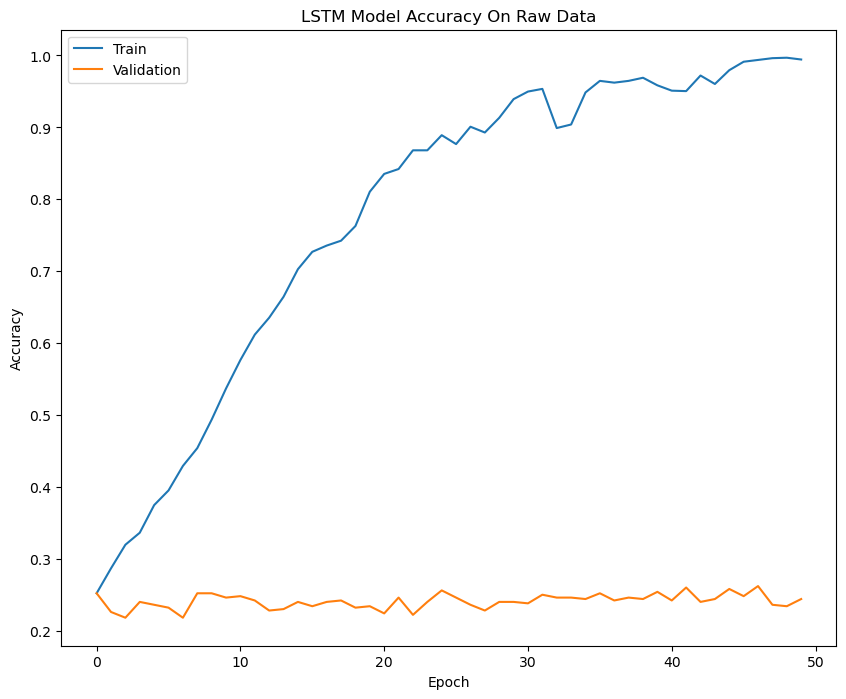

In [91]:
plt.plot(np.arange(50), LSTM_history['train_acc'], label='Train')
plt.plot(np.arange(50), LSTM_history['val_acc'], label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy On Raw Data')

Text(0.5, 1.0, 'LSTM Model Accuracy On Raw Data')

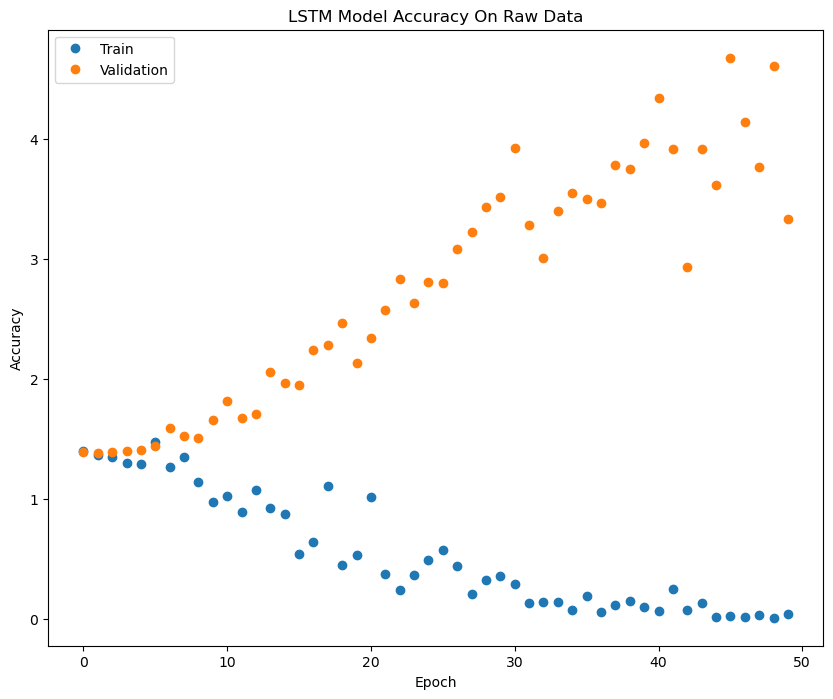

In [92]:
plt.plot(np.arange(50), LSTM_history['train_loss'],'o', label='Train')
plt.plot(np.arange(50), LSTM_history['val_loss'],'o', label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy On Raw Data')